## Откройте файл с данными и изучите общую информацию

### Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

Принципиальные шаги для работы с данными проектом:
- Шаг 1. Откройте файл с данными и изучите общую информацию
- Шаг 2. Подготовьте данные
- Шаг 3. Проведите исследовательский анализ данных
- Шаг 4. Составьте портрет пользователя каждого региона
- Шаг 5. Проверьте гипотезы
- Шаг 6. Напишите общий вывод

### Знакомство с данными

В первую очередь необходимо добавить библиотеки, с которыми мы работали в этом учебном модуле:

In [ ]:
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

Запишем датасет в переменную и изучим ее:

In [ ]:
data = pd.read_csv('/datasets/games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


11 столбцов отборных данных для меня и моего сына. Как мы видим названия столбцов - не по ГОСТу, обработаем в следующем разделе. Также ситуация неприятная с пропусками в последних трех столбцах их почти половина, посмотрим, что сможем сделать с ними. User_Score и Rating - речь скорее всего идет о числовых значениях - но записаны, как символьные, тоже обратим внимание.

## Подготовьте данные

### Заменим названия столбцов (приведем к нижнему регистру)

Приведем к нижнему регистру с помощью строчного метода **lower()**!

In [ ]:
data.columns = data.columns.str.lower()
#data.info()

### Преобразуем данные в нужные типы. Опишем, в каких столбцах заменили тип данных и почему

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Как я писал выше, user_score и rating - речь скорее всего идет о числовых значениях - но записаны, как символьные. Также обратим внимание на столбец year_of_release - вряд ли год - число не целое.

In [ ]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
# data['user_score'] = data['user_score'].astype('float64')
# data['rating'] = data['rating'].astype('float64')
# data['rating'].unique()

При выполнении кода выше, выяснилось, что столбец user_score заполнен помимо чисел и нанов еще и строчным значением 'tbd'. Надо обработать, чтобы привести к нормальному типу данных. Аббревиатура tbd значит to be determined - значит, предстоит определить, логично пока что заполнить Nan-type. Также в rating обнаружена строка Е. Да и в целом рейтинг записан в какой-то странной системе исчисления, потому что я плохо прочитал постановку задачи. Это рейтинг какой-то ассоциации, который присваивает еще и возрастной рейтинг, поэтому приводить к float не будем.

In [ ]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'] = data['user_score'].astype('float')

### Обработаем пропуски при необходимости

Изучим количество и нахождение пропусков в датасете.

In [ ]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Два пропуска в названии игры и жанре - вряд ли мы сможем по каким-то данным определить, что там за пропуск, лучше удалить эти 2 строки, не такая великая потеря. С годом тоже непонятно что делать - заполнить медианной и средним идея выглядит не лучшей, поэтому потерять 269 строк тоже вариант. С остальными пропусками история не лучше, к сожалению, да и пропусков много, и просто удалить их не выйдет(

In [ ]:
data = data.dropna(subset=['name','year_of_release','genre']).reset_index(drop=True)

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [ ]:
data['world_sales'] = (data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'])

### Осуществим проверку на дубликаты.

In [ ]:
data.duplicated().sum()

0

Ни одной повторяющейся строчки, и это здорово.

**Вывод по главе:** Данные были зачищены и приведены в нужный тип данных для дальнейшего анализа.

## Проведем исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Изучим столбец с годом, в датасете представлена статистика с 1980 по 2016 год. Построим гистограмму для них.

count    16444.000000
mean      2006.486256
std          5.875525
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64


<AxesSubplot:>

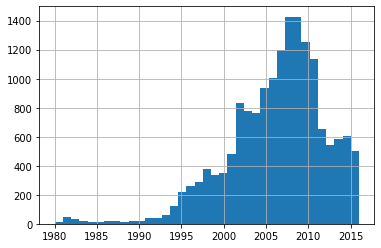

In [ ]:
print(data['year_of_release'].describe())
data['year_of_release'].hist(bins = 37)

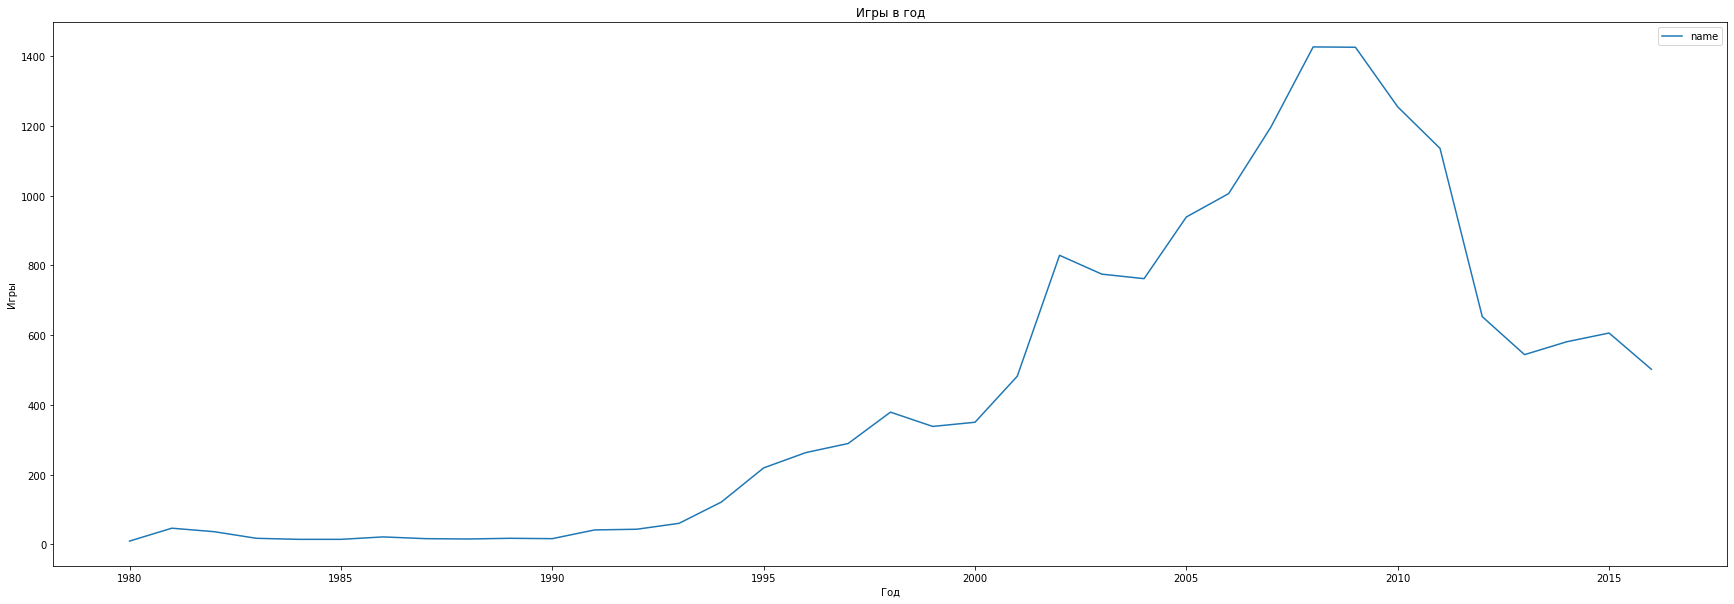

In [ ]:
# альтернативный график
games_per_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(30,10))
seaborn.lineplot(data=games_per_year)
plt.title("Игры в год")
plt.xlabel("Год")
plt.ylabel("Игры")
plt.show()

Наблюдаем, что первые 20 лет заданного периода - были достаточно скупы на производство игр. Более трех четвертых датасета распалагается в периоде с нулевых до 2016 года. Стабильный рост до 2007-2008 года, а потом спад? Это может быть связано с расцветом мобильных телефонов и локальных игр на них, может они начали обретать популярность и разработчики решили тратить свои силы именно на мобильную разработку. Думаю самый важный период - с 1995 года, хвост справа можно отбросить, хотя мы можем потерять много статистики для эпохальных приставок того времени.
В целом на впорос - важны ли периоды, логично сказать, что да, поскольку на начале пути были популярны сеги и подобные приставки, в рассвет же индустрии PS И X-box, забрали пальму первенства, ну и закатные годы - появление игры на персональные компьютеры и мобильные устройства.

### Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Посмотрим гистограмму по всем продажам. Применим библиотеку seaborn, которой мы пользовались лишь на вводном курсе, но она полна функционала, да и в целом делает жизнь красочнее.

Text(0, 0.5, 'Количество продаж')

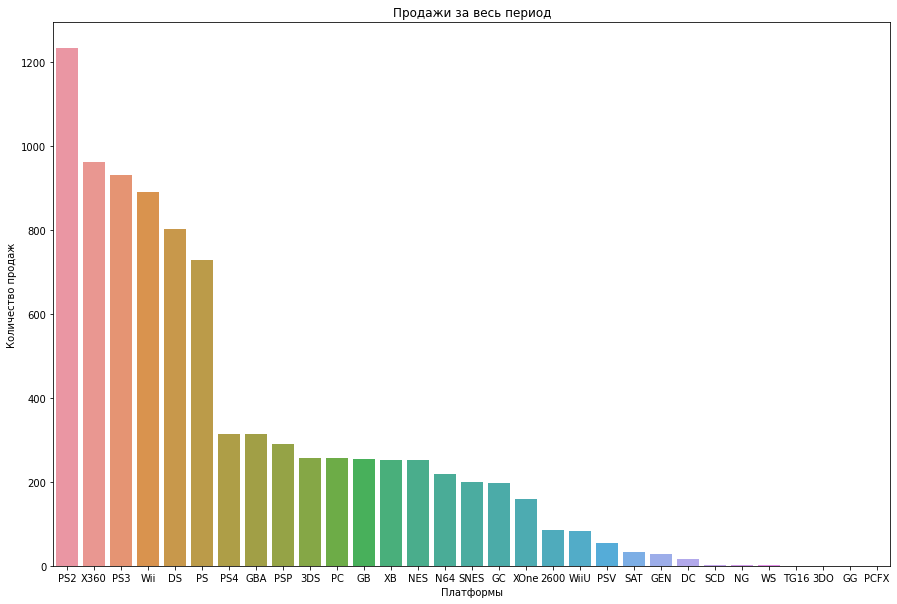

In [ ]:
platforms_ascending = data.pivot_table(index ='platform',values='world_sales',aggfunc='sum').sort_values(
    by='world_sales', ascending=False)

plt.figure(figsize=(15,10))
seaborn.barplot(x=platforms_ascending.index,y=platforms_ascending['world_sales'])
plt.title("Продажи за весь период")
plt.xlabel("Платформы")
plt.ylabel("Количество продаж")

Как мы видим, у нас есть явно выбивающиеся фавориты - целых 6 штук. Сохраним их отдельно, чтобы не потерять для дальнейшего анализа.

In [ ]:
top6_platforms = platforms_ascending.head(6)
top6_platforms = top6_platforms.reset_index().rename_axis(None, axis=1)
top6_platforms

,platform,world_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58


Построим распределение по годам для наших фаворитов:

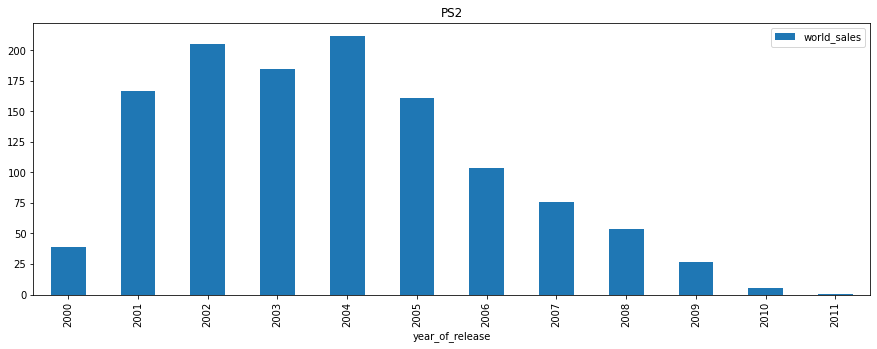

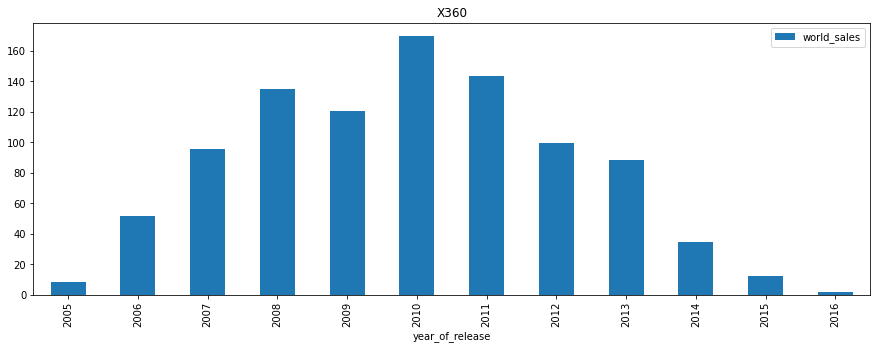

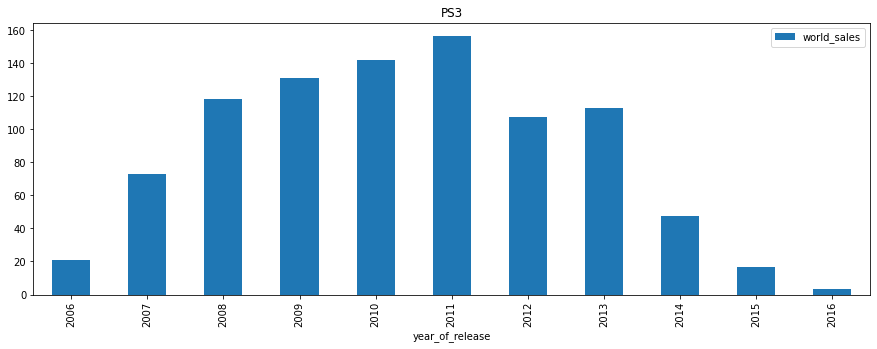

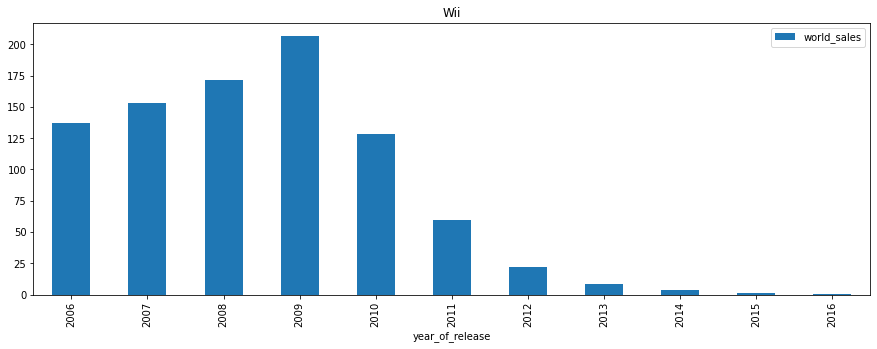

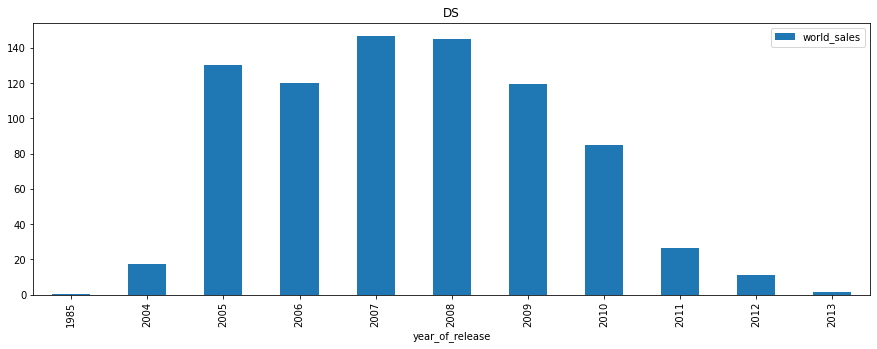

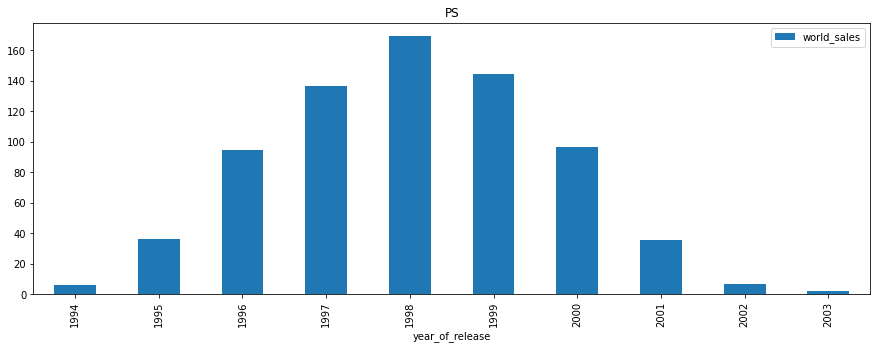

In [ ]:
for platform in top6_platforms['platform']:
    data[data['platform'] == platform].pivot_table(index='year_of_release',values='world_sales', aggfunc='sum').plot(
        kind='bar',figsize=(15,5))
    plt.title(platform)

Построили гистограмы для всех платформ разом и оценим их:
- PS2 Появилась в 2000 году, расцвет приходится на 2001-2005 год, дальше на падение, последняя игра в 2011 году, значит актуальный срок выхода на нее игр - около 10 лет;
- Х360 Появилась в 2005 году, расцвет приходится на 2006-2013 год, дальше на падение, последняя игра в 2016 году, значит актуальный срок выхода на нее игр также 10 лет;
- PS3 Появилась на замену PS2 в 2006 году, расцвет пришелся на 2007-20014 год, дальше на падение, последняя игра в 2016 году, значит актуальный срок около 10 лет. Стоит отметить, что с ее выходом - завершился расцвет PS2, пользователи видимо начали переходить на новые модели;
- Wii Появилась в 2006 году, расцвет приходится на 2006-2011, дальше на спад, последняя игра вышла в 2016 году;
- DS Вышла в 1985:??? Выглядит, как ошибка в датасете, стоит удалить данную строчку! Без нее очевидно вышла в 2004, рассвет на 2005-2011. Последняя игра в 2013.
- PS Появилась в 1994, расцвет 1995-2001, последняя игра в 2003. Снова закат приходится на выход новой версии PS2!

Првоерим странную строчку с платформой DS. Одни нули, да наны, очевидно вброс. Казнить, нельзя помиловать.

In [ ]:
data[(data['platform'] == 'DS') & (data['year_of_release'] == 1985)]
data = data.query("index != 15704")

За какой характерный срок появляются новые и исчезают старые платформы? Вообще жизненный цикл каждой платформы колеблется от 9 до 11 лет, грубо говоря 10. Но производители суетятся раньше, на примере PS, мы видим, что первая вышла в 94 году, вторая в 2000, а третья 2006 году. Новые версии подготовливают чуть раньше жизненного цикла, скорее всего, чтобы у пользователя было время подумать о покупке новой модели, прежде чем старая окончательно не сможет вывести новые игры, чем разочарует пользователя.

### Возьмем данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.


Даже пояснение, что значит актуальный период в меня не вселило уверенности. Вероятно речь идет о периоде крайнем, потому что строить на 2017 рационально на данных с 2012, как видно на гистограмме, примерно тут зафиксировались стабильные продажи, остановив влияние мобильных и пк

В рамках бизнесса не принято брать большие интервалы, поэтому мы будем ориентироваться на данные трехлетней давности, а именно с 2016 года.

<AxesSubplot:>

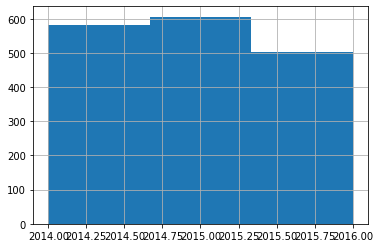

In [ ]:
data['year_of_release'].hist(bins=3, range=(2014,2016))

Как видим, здесь действительно все стабильно.

In [ ]:
actual_data = data.query("year_of_release > 2013")

### Не учитывайте в работе данные за предыдущие годы.

Этот пункт задания вызывает у меня некоторые вопросы, как можно не учитывать, если они помогут построить нам данные на 2017 год?

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Проведем тот же анализ, что был выше, только для данных с 2012 года.

Text(0, 0.5, 'Количество продаж')

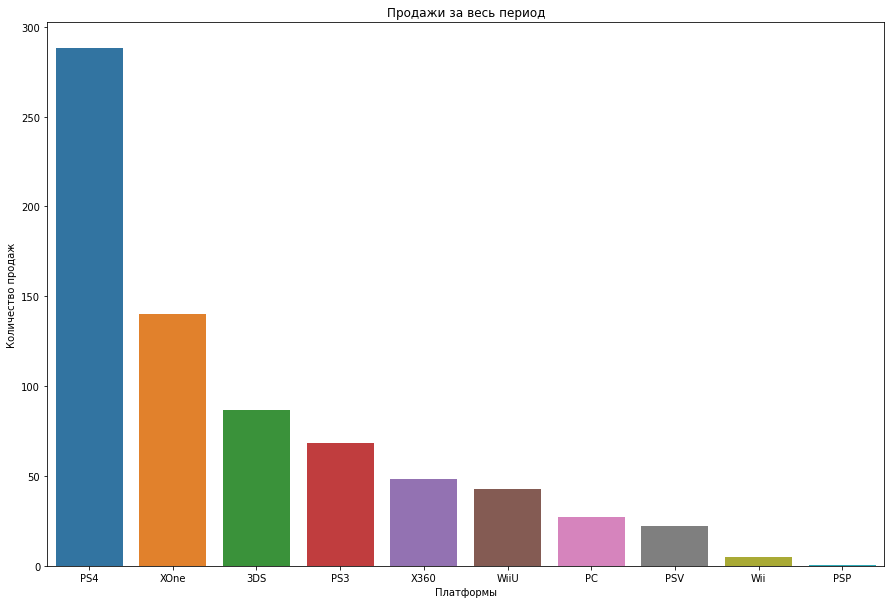

In [ ]:
actual_platforms_ascending = actual_data.pivot_table(index='platform', values='world_sales', aggfunc='sum').sort_values(
    by='world_sales', ascending=False)

plt.figure(figsize=(15,10))
seaborn.barplot(x=actual_platforms_ascending.index,y=actual_platforms_ascending['world_sales'])
plt.title("Продажи за весь период")
plt.xlabel("Платформы")
plt.ylabel("Количество продаж")

Выборка стала меньше - и слава Богу!

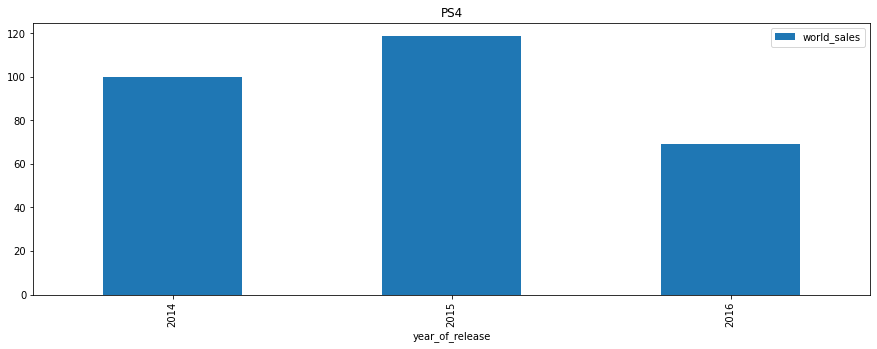

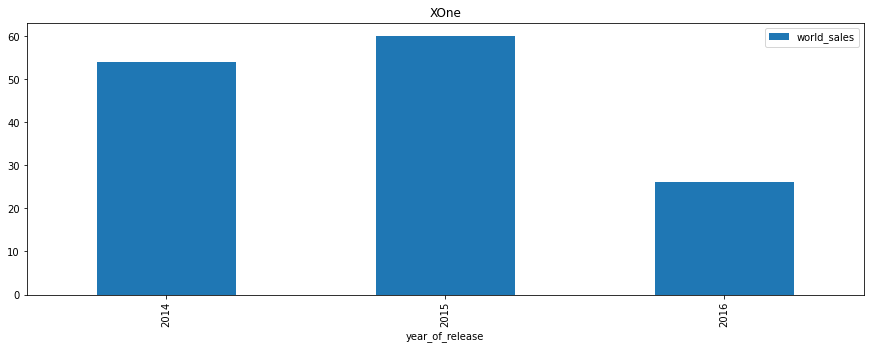

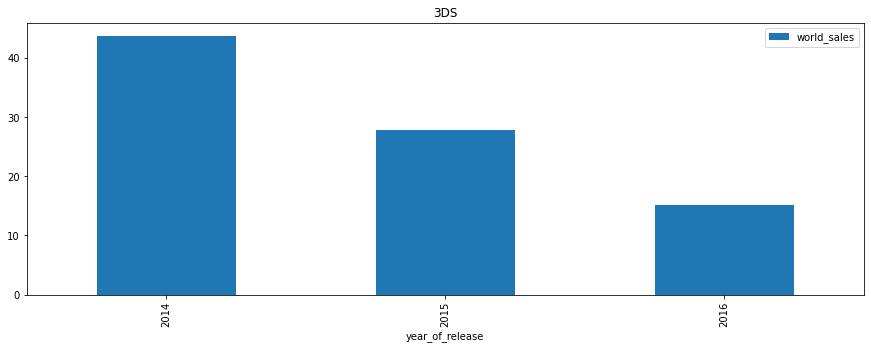

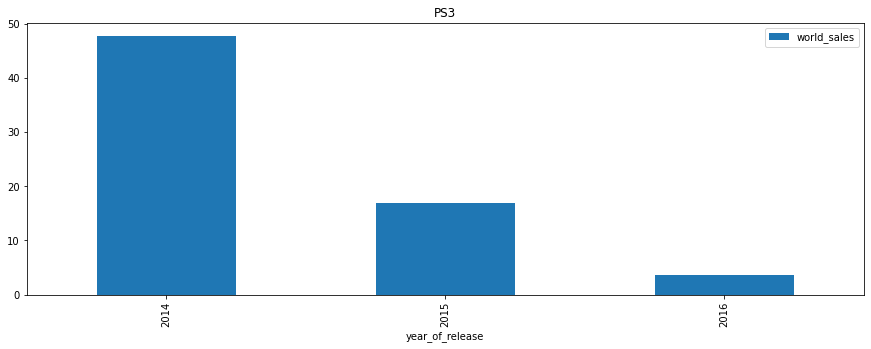

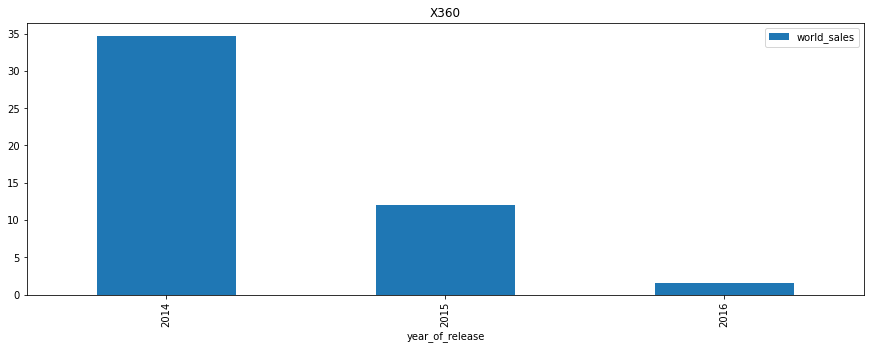

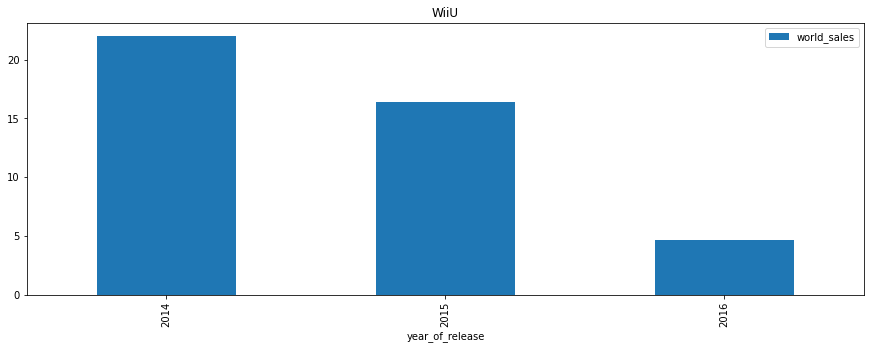

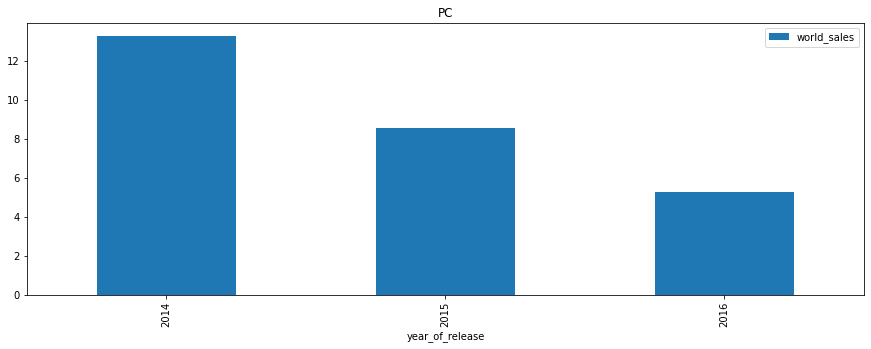

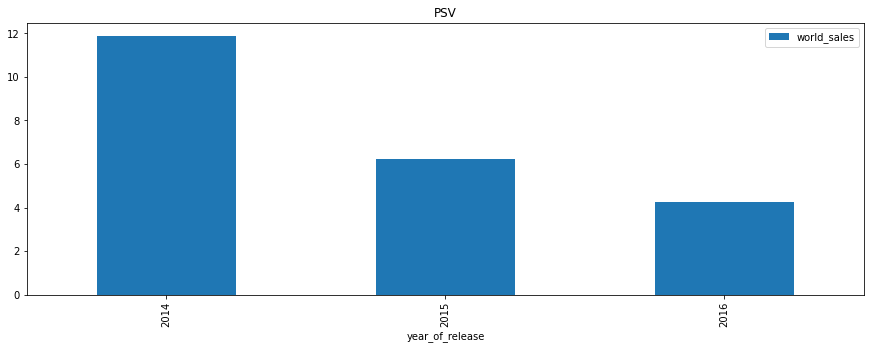

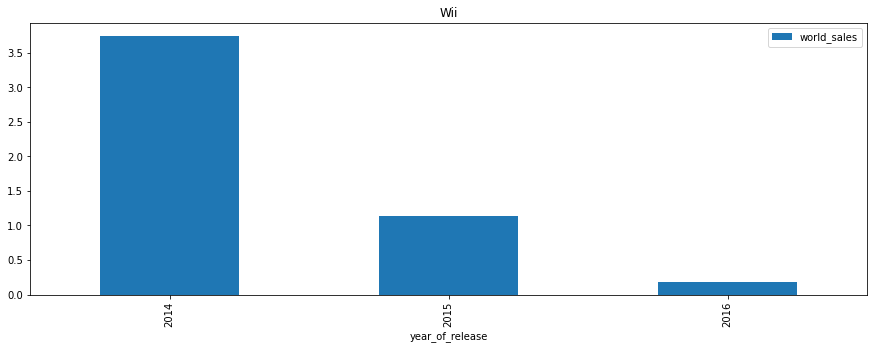

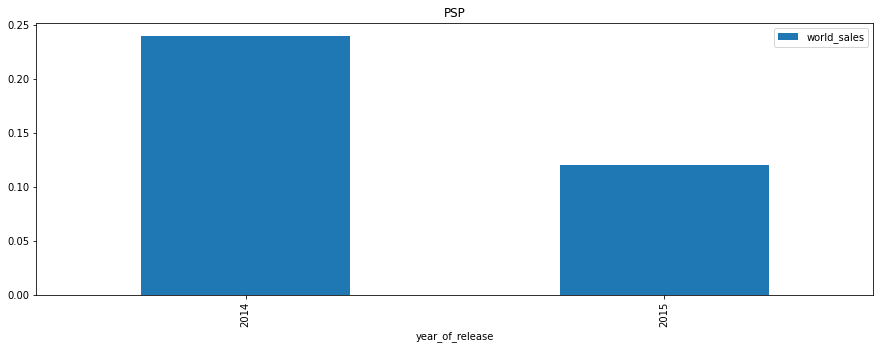

In [ ]:
actual_platforms = actual_platforms_ascending.reset_index().rename_axis(None, axis=1)
for platform in actual_platforms['platform']:
    actual_data[actual_data['platform']==platform].pivot_table(index ='year_of_release', values='world_sales', aggfunc='sum').plot(
        kind='bar', figsize=(15,5))
    plt.title(platform)

В целом все продажи идут из года в год с падением. Но можно выделить некоторые, которые еще остаются на плаву. Например: PS4, 3DS, XOne. Хуже дела идут у: PS3, X360, WiiU, PC, PSV, Wii. У DS и PSP - вообще нет данных за 2016 год, предположим, что они ушли с рынка и считать их актуальными - ошибка.

In [ ]:
actual_platforms = actual_platforms.head(9)
actual_data = actual_data.query('platform != "PSP"')
actual_data['platform'].unique()
actual_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16432,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16436,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16441,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат

<AxesSubplot:>

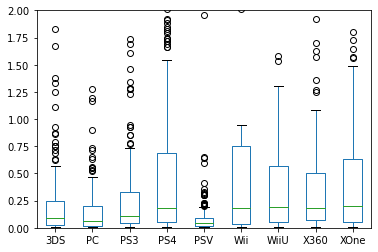

In [ ]:
actual_data.pivot_table(index='name',columns='platform', values='world_sales', aggfunc='sum').plot(kind='box', ylim=(0,2))

Как же много выбросов :C. В целом хорошее медианное значение наблюдается у WiiU, PS4 и X360, Wii, XOne. У них так же хорошее смещение в бОльшую сторону и это замечательно.

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируем выводы.


Рассмотрим Х360, по той причине, что он входит в топ продаж всего, и в актуальный период, будет хорошим примером.

In [ ]:
X360 = data[data['platform']=='X360']
print('Корреляция отзывов пользователей и продаж =', X360['user_score'].corr(X360['world_sales']))
print('Корреляция отзывов критиков и продаж =', X360['critic_score'].corr(X360['world_sales']))
print('Корреляция отзывов критиков и пользователей =', X360['critic_score'].corr(X360['user_score']))

Корреляция отзывов пользователей и продаж = 0.11418661214018049
Корреляция отзывов критиков и продаж = 0.39286589254006954
Корреляция отзывов критиков и пользователей = 0.6250204504122275


<AxesSubplot:xlabel='critic_score', ylabel='world_sales'>

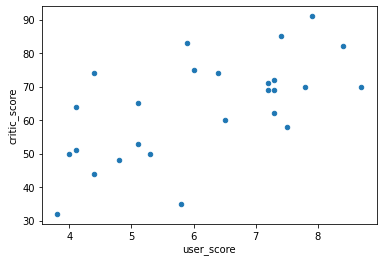

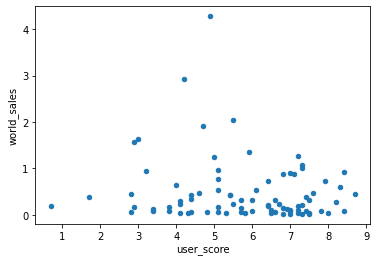

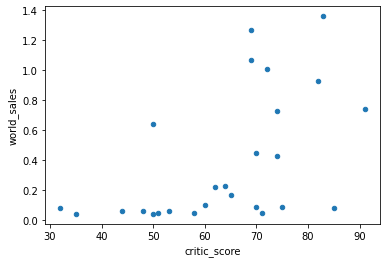

In [ ]:
X360 = actual_data.query('platform == "X360"')
X360.plot(x='user_score', y='critic_score', kind='scatter')
X360 = actual_data.query('platform == "X360"')
X360.plot(x='user_score', y='world_sales', kind='scatter')
X360 = actual_data.query('platform == "X360"')
X360.plot(x='critic_score', y='world_sales', kind='scatter')

Коэффициент корелляции говорит нам о том, что связь между пользовательскими отзывами слабая положительная, а у критиков средняя положительная, значит, критики действительно не просто так получают свою зарплату, правда и связь не назовешь сильной. Зато, корреляция между отзывами высокая, значит даже простой человек вполне может дать близкую к критику оценку. Построим диаграмму рассеяния.

### Соотнесем выводы с продажами игр на других платформах.

Вряд ли необходимо строить для каждой диаграмму, все-таки по числовым значениям попроще ориентироваться, рассмотрим только актуальные, и с помощью сводной таблицы все быстро оформим.

In [ ]:
y = list(actual_platforms['platform'])
y
for i in y:
    x = actual_data.query('platform == @i')
    cor = x[['critic_score','user_score', 'world_sales']]
    print('Корреляция для платформы', i)
    display(cor.corr())
    print()
#actual_data.query('platform == "Wii"')

Корреляция для платформы PS4


,critic_score,user_score,world_sales
critic_score,1.000000,0.546434,0.402661
user_score,0.546434,1.000000,-0.040132
world_sales,0.402661,-0.040132,1.000000



Корреляция для платформы XOne


,critic_score,user_score,world_sales
critic_score,1.000000,0.440977,0.428677
user_score,0.440977,1.000000,-0.070384
world_sales,0.428677,-0.070384,1.000000



Корреляция для платформы 3DS


,critic_score,user_score,world_sales
critic_score,1.000000,0.862485,0.314117
user_score,0.862485,1.000000,0.215193
world_sales,0.314117,0.215193,1.000000



Корреляция для платформы PS3


,critic_score,user_score,world_sales
critic_score,1.000000,0.693445,0.446575
user_score,0.693445,1.000000,-0.166761
world_sales,0.446575,-0.166761,1.000000



Корреляция для платформы X360


,critic_score,user_score,world_sales
critic_score,1.000000,0.625309,0.525723
user_score,0.625309,1.000000,-0.138445
world_sales,0.525723,-0.138445,1.000000



Корреляция для платформы WiiU


,critic_score,user_score,world_sales
critic_score,1.000000,0.763536,0.370201
user_score,0.763536,1.000000,0.407926
world_sales,0.370201,0.407926,1.000000



Корреляция для платформы PC


,critic_score,user_score,world_sales
critic_score,1.000000,0.466099,0.174634
user_score,0.466099,1.000000,-0.071597
world_sales,0.174634,-0.071597,1.000000



Корреляция для платформы PSV


,critic_score,user_score,world_sales
critic_score,1.000000,0.524066,0.042665
user_score,0.524066,1.000000,-0.168455
world_sales,0.042665,-0.168455,1.000000



Корреляция для платформы Wii


,critic_score,user_score,world_sales
critic_score,NaN,NaN,NaN
user_score,NaN,1.0,1.0
world_sales,NaN,1.0,1.0


Как мы наблюдаем для всех случаев, кроме PC и XONE, выше среднего коррелируют отзывы критиков и простых работяг. С продажами у критиков похуже. Однако отзывы пользователей еще хуже коррелируют с продажами, поэтому нагонять жути на критиков не стоит. Как мы видим, статистика для Wii не отобразилась, если обратиться к срезу, то можно увидеть почти полное отсуствие оценок, как пользовательских, так и критиков, к сожалению, никаких выводов по этой плафторме сделать не выйдет.

### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Построим сводную таблицу с жанрами и продажами. И построим по ней гистограму, какую делали ранее с платформами.

In [ ]:
sale_genre = actual_data.pivot_table(index='genre', values='world_sales', aggfunc='mean').sort_values(by='world_sales', ascending=False)
sale_genre = sale_genre.reset_index().rename_axis(None, axis=1)
sale_genre

,genre,world_sales
0,Shooter,1.335469
1,Sports,0.683688
2,Platform,0.476053
3,Fighting,0.470333
4,Role-Playing,0.459005
5,Racing,0.398841
6,Misc,0.338108
7,Action,0.324894
8,Simulation,0.298409
9,Puzzle,0.157857


Text(0, 0.5, 'Среднее продаж')

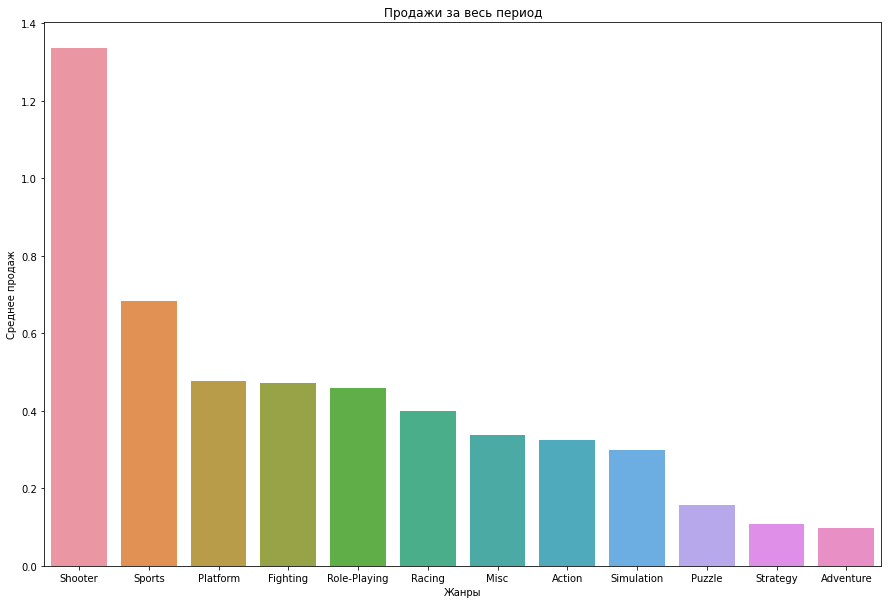

In [ ]:
plt.figure(figsize=(15,10))
seaborn.barplot(x=sale_genre['genre'],y=sale_genre['world_sales'])

plt.title("Продажи за весь период")
plt.xlabel('Жанры')
plt.ylabel("Среднее продаж")

Самые прибыльные: игры жанра шутер, спорт и платформеры. Приключения, стратегии и пазлы на последних местах.

**Вывод по главе:** Были проведены различные манипуляции в интересах данных, выяснили:
- Все данные при желании можно поделить на 3 периода.
- Средний срок жизни платформы около 10 лет. Но производители стараются уложиться в рамках 7 и выпускают новую версию.
- Был определен топ лучших платформ по актуальному периоду.
- По платформам из актуального периода построен и проанализирован график ящик с усами.
- Выяснили, что пользователи и критики похожи в своих взглядах, но у последних более подвешен глаз на прибыльные проекты.
- Был определен топ жанров игр.

## Определите для пользователя каждого региона (NA, EU, JP):

Опишем функции для анализа следующих параметров:
- Самые популярные платформы.
- Самые популярные жанры.
- Влияет ли рейтинг ESRB на продажи.

In [ ]:
actual_data['rating'] = actual_data['rating'].fillna('no rating')

def popular_platform(cntr):
    actual_data.pivot_table(
        index = 'platform', values = cntr, aggfunc = 'sum').sort_values(
        ascending=False, by = cntr).plot(kind = 'bar', figsize=(15,5))

def popular_genre(cntr):
    actual_data.pivot_table(
        index = 'genre', values = cntr, aggfunc = 'sum').sort_values(
        ascending=False, by = cntr).plot(kind = 'bar', figsize=(15,5))

#def ESRB_influence(cntr):
    #ESRB = pd.pivot_table(actual_data, index='rating', values=cntr,aggfunc='sum').sort_values(cntr, ascending=False)
    #ESRB почему то без функции - работает, с ней - нет:C

### Определим для пользователя региона NA необходимые параметры

,na_sales
rating,
M,96.42
no rating,64.72
E,50.74
T,38.95
E10+,33.23


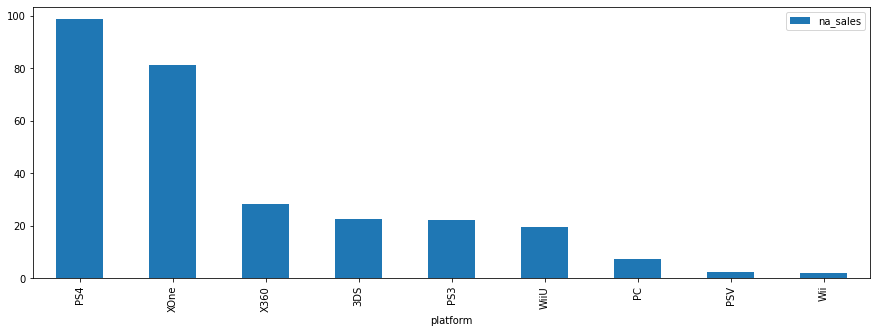

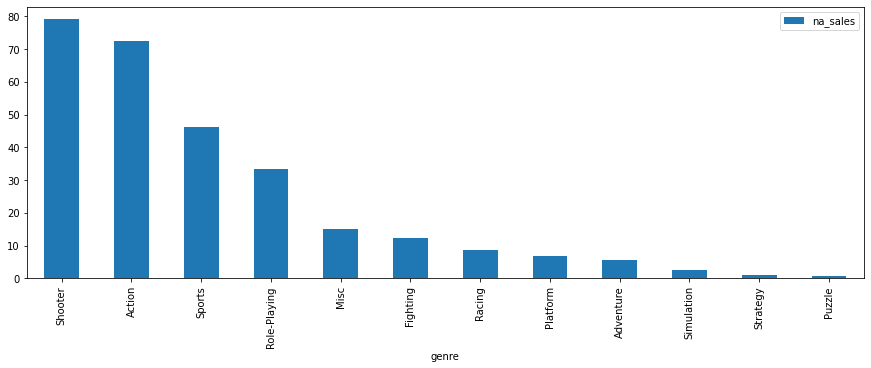

In [ ]:
popular_platform('na_sales')
popular_genre('na_sales')
pd.pivot_table(actual_data, index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)

В Северной Америке преобладают игры с рейтингом М. Самые популярные приставки - X360, PS4, PS3, XOne и 3DS. Жанры - экшен, шутер, спортивные игры, ролевые и музыкальные.

### Определим для пользователя региона EU необходимые параметры

,eu_sales
rating,
M,93.44
no rating,58.95
E,58.06
T,34.07
E10+,26.16


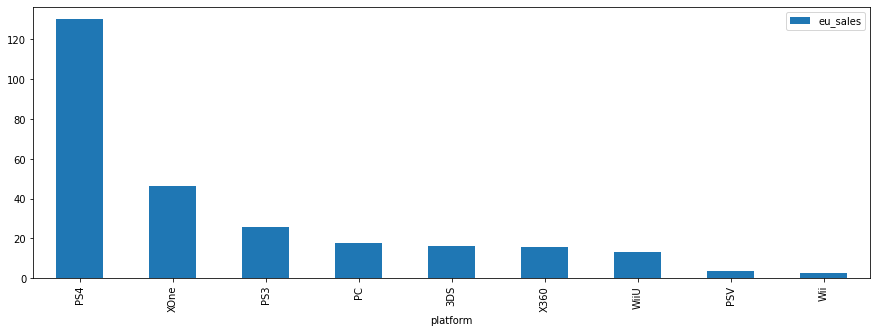

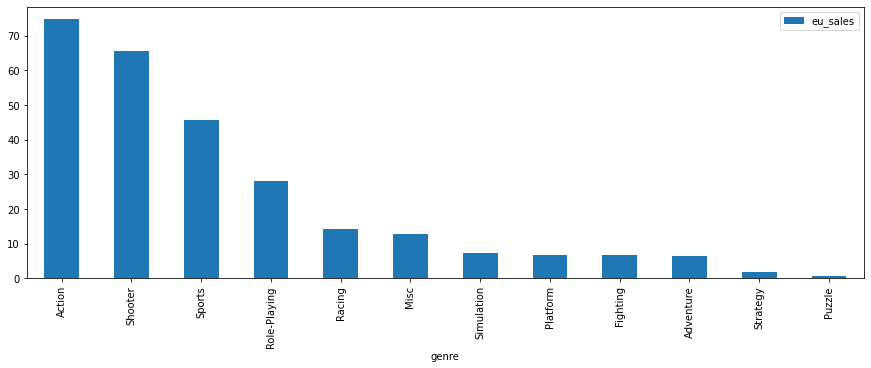

In [ ]:
popular_platform('eu_sales')
popular_genre('eu_sales')
pd.pivot_table(actual_data, index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)

В Европе преобладают игры с рейтингом М. В целом показатели похожи с Северрной америкой в плане рейтинга. Самые популярные приставки - PS4, PS3, PC, XOne и 3DS. Жанры - экшен, шутер, спортивные игры, ролевые и гонки. Портрет американца и европейца очень похож, не удивительно, ведь американцы это иммигрировавшие когда-то из европы люди.

### Определим для пользователя региона JP необходимые параметры

,jp_sales
rating,
no rating,56.54
T,14.78
E,8.94
M,8.01
E10+,4.46


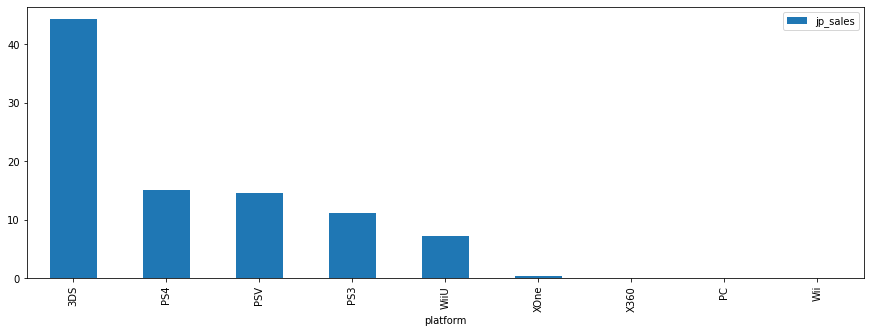

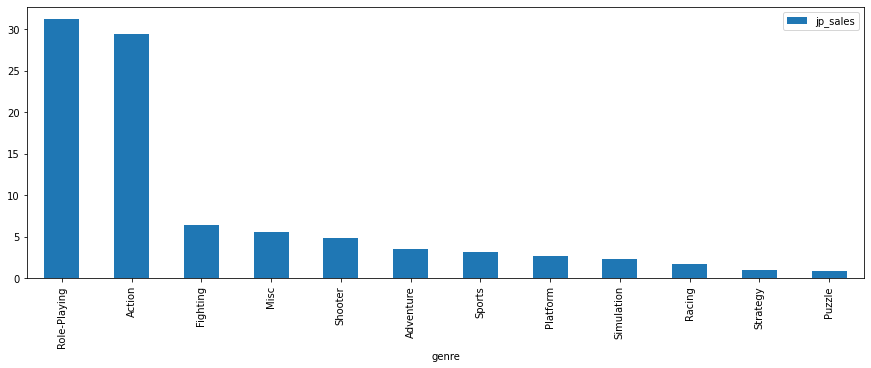

In [ ]:
popular_platform('jp_sales')
popular_genre('jp_sales')
pd.pivot_table(actual_data, index='rating', values='jp_sales',aggfunc='sum').sort_values('jp_sales', ascending=False)

В Японии в целом популярность по рейтингу примерно одинакова, не считая игр без рейтинга, они доминируют, не знаю почему. Самые популярные приставки - 3DS, PS3, PSV, PS4, WiiU. Жанры - ролевые, экшен, музыкальные игры, симуляторы и шутеры.
Здесь картина уже существенно меняется, как по рейтингам, по платформам и жанрам. Чувствуется совсем другой менталитет.

**Вывод по главе:** Сравнили портреты пользователей разных регионов. Пришли к выводу, что американцы ближе европейцам по игровым вкусам, нежели японцы.

## Проверим гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Для проверки гипотезы воспользуемся критерием Стьюдента. Критерий Стьюдента относится к одному из наиболее давно разработанных и широко используемых методов статистики. Чаще всего он применяется для проверки нулевой гипотезы о равенстве средних значений двух совокупностей. В результате проверки можем получить два случая, "Отвергаем нулевую гипотезу" и "Не получилось отвергнуть нулевую гипотезу". При получении ответа "Отвергаем нулевую гипотезу" это говорит о том, что гипотеза противоречит данным и скорей всего наше предположение неверно и наоборот.

Наши гипотезы:
- Н0 (нулевая) - средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- H1 (альтернативная) - средние пользовательские рейтинги платформ Xbox One и PC неодинаковые.

Сделаем необходимые нам в аналитике срезы:
Брать Nan и 0 рейтинги не будем, 0 - человек ставит скорее всего ставит который не смог скачать и оценить игру.

In [ ]:
XOne = actual_data.query("platform == 'XOne' & user_score > 0")
PC = actual_data.query("platform == 'PC' & user_score > 0")
# PC['user_score'].count()
# XOne['user_score'].count()

<AxesSubplot:>

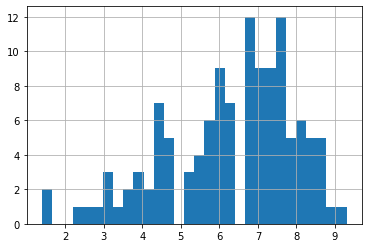

In [ ]:
PC['user_score'].hist(bins = 30)

<AxesSubplot:>

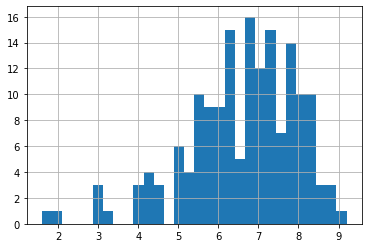

In [ ]:
XOne['user_score'].hist(bins = 30)

Тяжело что-то сказать точно по гистограмам, однако, кажется, что первая игра была чуть более успешна. Для оценки гипотезы применим тест Стюдента.
Если отвергаем нулевую гипотезу, значит, наше предположение неверно и средняя оценка отлична и наоборот. Альфа возьмем по золотому стандарту .05. Объем двух выборок - около 200, вполне себе кажется достаточным для анализа.

In [ ]:
alpha = .05

results = st.ttest_ind(
    XOne['user_score'],
    PC['user_score'],
    equal_var=False,
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


p-value получили равным ~11%. Значит наша нулевая гипотеза вполне состоятельна и условий для отвержения ее недостаточно.

### Средние пользовательские рейтинги жанров Action и Sports разные

Наши гипотезы:
- Н0 (нулевая) - средние пользовательские рейтинги жанров Action и Sports одинаковые;
- H1 (альтернативная) - средние пользовательские рейтинги жанров Action и Sports неодинаковые.

In [ ]:
action = actual_data.loc[actual_data['genre']=='Action'].user_score.dropna().values
sports = actual_data.loc[actual_data['genre']=='Sports'].user_score.dropna().values

In [ ]:
alpha = .05

if st.ttest_ind(action,sports,equal_var=False).pvalue>alpha:
    print('p-значение:', st.ttest_ind(action,sports,equal_var=True).pvalue)
    print('Не можем отклонить нулевую гипотезу')
else:
    print('p-значение:', st.ttest_ind(action,sports,equal_var=True).pvalue)
    print('Отклоняем нулевую гипотезу о равенстве средних')


p-значение: 2.8711147985105864e-19
Отклоняем нулевую гипотезу о равенстве средних


Получить одинаковые средние по двум данным жанрам на грани невозможного в этой вселенной.

**Вывод по главе:** для проверки гипотез воспользовались тестом Стьюдента. Пришли к выводу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые и средние пользовательские рейтинги жанров Action и Sports неодинаковые.

## Общий вывод

В ходе подготовки данных к аналитике были выполнены:
- Очистка датасета от пропусков, где это возможно.
- Удаление ненужных, неинформативных строк.
- Приведение данных к нужному типу данных.

В ходе аналитической работы были выявлены следующие закономерности:
- Все данные о платформах при желании можно поделить на 3 периода.
- Средний срок жизни платформы около 10 лет. Но производители стараются уложиться в рамках 7 и выпускают новую версию.
- По актуальному периоду лидируют PS4 и XOne.
- Пользователи и критики похожи в своих взглядах, но у последних более подвешен глаз на прибыльные проекты.
- Наипопулярный и актуальный жанр игр - Экшен.

В ходе проверки гипотез выяснилось, что:
- Cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Cредние пользовательские рейтинги жанров Action и Sports разные.